In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [75]:
pd.set_option('display.max_columns',None)

In [3]:
train_df = pd.read_csv('house-pricing-data/train.csv')
test_df = pd.read_csv('house-pricing-data/test.csv')

print(train_df.shape)
train_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# before changing values, let's keep the original dataframe unchanged!
train_copy = train_df.copy()

In [6]:
train_copy

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [3]:
# let's fix null values
def see_na(df: pd.DataFrame) -> None:
    """
    Function that shows all the NaN values count for each columns in a DataFrame.
    """
    
    nulls = df.isna().sum()
    nulls = nulls[nulls>0]
    print(len(nulls), "null columns\n", nulls)

def pattern_check(df: pd.DataFrame, rgx: str):
    """
    Function works by using pattern regex 'rgx' parameter to look for columns 
    that fit that pattern
    """
    
    return df.filter(regex=rgx)

def rename_cols(df: pd.DataFrame, cols: list, cols_newname: list):
    """
    Function that renames columns in a DataFrame, both column parameters
    need to have the same length, and the order of the names must be the same.
    """
    
    for i, j in zip(cols, cols_newname):
        df.rename(columns={i: j}, inplace=True)
    return df

def corr_matrix(corr: pd.DataFrame) -> None:
    """
    This function presents a correlation matrix on the 'corr' variable.
    """
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)

    plt.xticks(rotation=45)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    

In [8]:
# Electrical NaN first
train_copy.loc[train_copy['Electrical'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [9]:
# SBrkr is so much common than any other that it's probably safe to set the NaN record to SBrkr
train_copy['Electrical'].value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [6]:
# defining the mode
electrical_mode = train_copy['Electrical'].mode()[0]
train_copy.replace({'Electrical': np.nan}, electrical_mode, inplace=True)

In [11]:
see_na(train_copy)

18 null columns
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [ ]:
# Now MasVnrArea which basically tells us the general area of veneer on the walls (inside + outside)
# And MasVnrType which is the type of wall veneer

In [12]:
print(train_copy['MasVnrType'].unique())

# not problematic, means there's no veneer
train_copy.loc[train_copy['MasVnrType'].isna() & (train_copy['MasVnrArea'] == 0)]

['BrkFace' nan 'Stone' 'BrkCmn']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1455,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,410,Unf,0,811,1221,GasA,Ex,Y,SBrkr,1221,0,0,1221,1,0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2004.0,RFn,2,400,TA,TA,Y,0,113,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,185000
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1

In [13]:
# partially problematic (MasVnrArea should be set to 0 instead of NaN or other values)
# this is partially problematic because implies that there's no veneer type but there's a veneer area
train_copy.loc[train_copy['MasVnrType'].isna() & (train_copy['MasVnrArea'] != 0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
624,625,60,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,1972,1972,Gable,CompShg,VinylSd,VinylSd,NaN,288.0,TA,TA,CBlock,TA,TA,No,Rec,247,Unf,0,485,732,GasA,Gd,Y,SBrkr,1012,778,0,1790,1,0,1,2,4,1,TA,8,Min2,1,TA,Attchd,1972.0,RFn,2,484,TA,TA,Y,148,0,0,0,147,0,NaN,NaN,NaN,0,11,2006,WD,Normal,165150
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
773,774,20,RL,70.0,10150,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,5,1958,1958,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,1.0,TA,TA,CBlock,TA,TA,No,Rec,456,Unf,0,456,912,GasA,Ex,Y,FuseA,912,0,0,912,0,0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1958.0,RFn,1,275,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,COD,Normal,114500
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1230,1231,90,RL,NaN,18890,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,RRAe,Duplex,1.5Fin,5,5,1977,1977,Shed,CompShg,Plywood,Plywood,NaN,1.0,TA,TA,CBlock,Gd,TA,No,GLQ,498,Rec,211,652,1361,GasA,Ex,Y,SBrkr,1361,1259,0,2620,0,0,2,2,4,2,TA,12,Typ,1,TA,BuiltIn,1977.0,RFn,2,600,TA,TA,N,155,24,145,0,0,0,NaN,NaN,Gar2,8300,8,2007,WD,Normal,190000
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,6

In [14]:
# not problematic
# and this is not problematic because there's a veneer type and an area
train_copy.loc[train_copy['MasVnrType'].notna() & (train_copy['MasVnrArea'] != 0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1962,1962,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,TA,TA,No,Rec,593,Unf,0,595,1188,GasA,TA,Y,SBrkr,1188,0,0,1188,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1962.0,Unf,1,312,TA,TA,P,261,39,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900
1447,1448,60,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,1995,1996,Gable,CompShg,VinylSd,VinylSd,BrkFace,438.0,Gd,TA,PConc,Gd,TA,No,GLQ,1079,Unf,0,141,1220,GasA,Ex,Y,SBrkr,1220,870,0,2090,1,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1995.0,RFn,2,556,TA,TA,Y,0,65,0,0,0,0,NaN,NaN,NaN,0,12,2007,WD,Normal,240000
1451,1452,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2008,2009,Gable,CompShg,CemntBd,CmentBd,Stone,194.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1573,1573,GasA,Ex,Y,SBrkr,1578,0,0,1578,0,0,2,0,3,1,Ex,7,Typ,1,Gd,Attchd,2008.0,Fin,3,840,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1452,1453,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,5,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,80.0,TA,TA,PConc,Gd

In [15]:
# problematic, there's veneer type but no area of the veneer
train_copy.loc[train_copy['MasVnrType'].notna() & (train_copy['MasVnrArea'] == 0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,689,20,RL,60.0,8089,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,392000
1241,1242,20,RL,83.0,9849,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,6,2007,2007,Hip,CompShg,VinylSd,VinylSd,Stone,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1689,1689,GasA,Ex,Y,SBrkr,1689,0,0,1689,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,3,954,TA,TA,Y,0,56,0,0,0,0,NaN,NaN,NaN,0,6,2007,New,Partial,248328


In [7]:
# these indexes need to have the MasVnrArea set to zero
# these indexes need to have the MasVnrType set to 'NoVnr'
vnr_area_index = train_copy.loc[train_copy['MasVnrType'].isna() & (train_copy['MasVnrArea'] != 0)].index
vnr_type_index = train_copy.loc[train_copy['MasVnrType'].notna() & (train_copy['MasVnrArea'] == 0)].index

In [8]:
train_copy.loc[vnr_type_index, 'MasVnrType'] = None
train_copy.loc[train_copy['MasVnrType'].isna(), 'MasVnrType'] = 'NoVnr'
train_copy.loc[vnr_area_index, 'MasVnrArea'] = 0

train_copy.loc[train_copy['LotFrontage'].isna(), 'LotFrontage'] = 0
train_copy.loc[train_copy['Alley'].isna(), 'Alley'] = 'NoAl'
train_copy.loc[train_copy['FireplaceQu'].isna(), 'FireplaceQu'] = 'NoFi'
train_copy.loc[train_copy['PoolQC'].isna(), 'PoolQC'] = 'NoPl'
train_copy.loc[train_copy['Fence'].isna(), 'Fence'] = 'NoFc'

Bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
train_copy.loc[train_copy[Bsmt_cols].isna().any(axis=1), Bsmt_cols] = 'Nb'

In [9]:
garage_cols = train_copy.filter(regex='^Garage').columns.tolist()
garage_cols.remove('GarageYrBlt')
garage_cols.remove('GarageArea')
garage_cols.remove('GarageCars')
train_copy.loc[train_copy[garage_cols].isna().any(axis=1), garage_cols] = 'NoG'
train_copy['GarageYrBlt']=train_copy['GarageYrBlt'].fillna(0)

train_copy = train_copy.drop('MiscFeature', axis=1)


In [19]:
see_na(train_copy)

0 null columns
 Series([], dtype: int64)


In [45]:
rename_cols(train_copy, ["YearBuilt", "YearRemodAdd"], ["YrBuilt", "Remod"])
pattern_check(train_copy, "^Yr|^Remod$")

,YrBuilt,Remod,YrSold
0,2003,2003,2008
1,1976,1976,2007
2,2001,2002,2008
3,1915,1970,2006
4,2000,2000,2008
...,...,...,...
1455,1999,2000,2007
1456,1978,1988,2010
1457,1941,2006,2010
1458,1950,1996,2010


Remod is a good feature that will be more useful for us if it's just 1 (remodelling was done), or 0 (no remodelling done)

In [46]:
train_copy["Age"] = train_copy["YrSold"] - train_copy["YrBuilt"]
train_copy["Remod"] = np.where(train_copy["Remod"] == train_copy["YrBuilt"], 0, 1)
pattern_check(train_copy, "^Remod$|^Age$")

,Remod,Age
0,0,5
1,0,31
2,1,7
3,1,91
4,0,8
...,...,...
1455,1,8
1456,1,32
1457,1,69
1458,1,60


In [53]:
train_copy['MSSubClass'] = train_copy['MSSubClass'].astype(str)

Using the numericals variable to get a correlation matrix

In [74]:
numericals = train_copy.select_dtypes(include=np.number)

In [85]:
numericals.head(2)

,LotArea,OverallQual,OverallCond,Remod,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MiscVal,Age,SalePrice
0,8450,7,5,0,196.0,856,856,854,8,0,548,0,61,0,0,0,5,208500
1,9600,6,8,0,0.0,1262,1262,0,6,1,460,298,0,0,0,0,31,181500


In [79]:
cols_cm = ['LotArea', 'OverallQual', 'OverallCond', 
           'Remod', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
          'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
          'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
          'PoolArea', 'MiscVal',  'Age', 'SalePrice']
numericals = numericals[cols_cm]

In [80]:
correlations = (
        numericals
        .corr()
        .round(2)
)

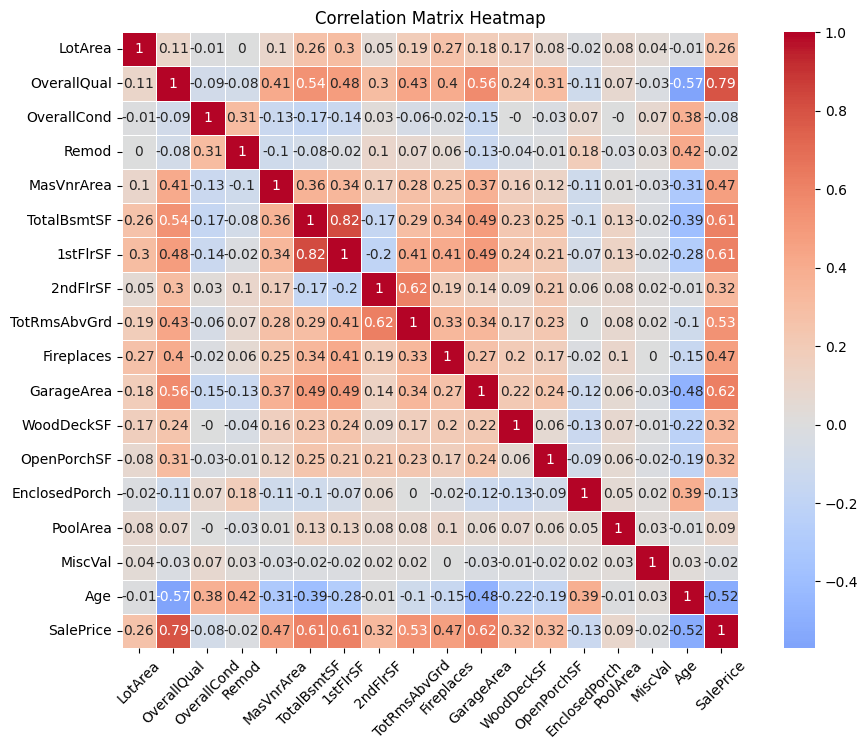

In [83]:
corr_matrix(correlations)

In [4]:
num_features = ['LotArea', 'OverallQual', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 
               'Age']

---

Let's save the train_copy dataframe to a csv

In [86]:
train_copy.to_csv("house-pricing-data/train_copy.csv", index=False)

In [76]:
df = pd.read_csv('house-pricing-data/train_copy.csv')
df['MSSubClass'] = df['MSSubClass'].astype(str)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YrBuilt,Remod,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,1,60,RL,65.0,8450,Pave,NoAl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFi,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPl,NoFc,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,NoAl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,0,Gable,CompShg,MetalSd,MetalSd,NoVnr,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPl,NoFc,0,5,2007,WD,Normal,181500,31
2,3,60,RL,68.0,11250,Pave,NoAl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,1,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPl,NoFc,0,9,2008,WD,Normal,223500,7
3,4,70,RL,60.0,9550,Pave,NoAl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1,Gable,CompShg,Wd Sdng,Wd Shng,NoVnr,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NoPl,NoFc,0,2,2006,WD,Abnorml,140000,91
4,5,60,RL,84.0,14260,Pave,NoAl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NoPl,NoFc,0,12,2008,WD,Normal,250000,8


In [77]:
encoding_feats = {'Nominal': ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 'Neighborhood', 
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
                'SaleType', 'SaleCondition'], 
                  'Ordinal': ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
               'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']}

In [78]:
nominal_encoded = pd.get_dummies(df[encoding_feats['Nominal']], dtype=float)
df_encoded = pd.concat([df, nominal_encoded], axis=1)
df_encoded = df_encoded.drop(df[encoding_feats['Nominal']].columns, axis=1)
df_encoded.head()

,Id,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YrBuilt,Remod,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,Age,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NoAl,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NoVnr,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoG,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,Reg,Lvl,Gtl,7,5,2003,0,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFi,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPl,NoFc,0,2,2008,208500,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

In [79]:
for i in df[encoding_feats['Ordinal']].columns:
    print(i, df[i].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'Nb' 'Fa']
BsmtCond ['TA' 'Gd' 'Nb' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'Nb']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'Nb' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'Nb' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
FireplaceQu ['NoFi' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'NoG']
GarageQual ['TA' 'Fa' 'Gd' 'NoG' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'NoG' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']
PoolQC ['NoPl' 'Ex' 'Fa' 'Gd']
Fence ['NoFc' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


In [80]:
ordinal_feats_order = [
    ['Reg', 'IR1', 'IR2', 'IR3'],                   # LotShape
    ['Low', 'HLS', 'Bnk', 'Lvl'],                   # LandContour  
    ['Gtl', 'Mod', 'Sev'],                          # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # ExterCond
    ['Nb', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],           # BsmtQual (Nb = No basement)
    ['Nb', 'Po', 'Fa', 'TA', 'Gd'],                 # BsmtCond
    ['Nb', 'No', 'Mn', 'Av', 'Gd'],                 # BsmtExposure
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType1
    ['Nb', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],                 # KitchenQual
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['NoFi', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],         # FireplaceQu
    ['NoG', 'Unf', 'RFn', 'Fin'],                   # GarageFinish
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageQual
    ['NoG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],          # GarageCond
    ['N', 'P', 'Y'],                                # PavedDrive
    ['NoPl', 'Fa', 'Gd', 'Ex'],                     # PoolQC
    ['NoFc', 'MnWw', 'MnPrv', 'GdWo', 'GdPrv']      # Fence
]

In [81]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_enc = OrdinalEncoder(categories=ordinal_feats_order, handle_unknown='use_encoded_value', unknown_value=-1 )

encoded_ordinals = ordinal_enc.fit_transform(df[encoding_feats['Ordinal']])

df_encoded[encoding_feats['Ordinal']] = encoded_ordinals

In [82]:
df_encoded.head()

,Id,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YrBuilt,Remod,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,Age,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NoAl,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NoVnr,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoG,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,0.0,3.0,0.0,7,5,2003,0,196.0,3.0,2.0,4.0,3.0,1.0,6.0,706,1.0,0,150,856,4.0,856,854,0,1710,1,0,2,1,3,1,3.0,8,6.0,0,0.0,2003.0,2.0,2,548,3.0,3.0,2.0,0,61,0,0,0,0,0.0,0.0,0,2,2008,208500,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [83]:
print('original df shape, rows: ', df.shape[0], ', columns: ', df.shape[1])

print('encoded df shape, rows: ', df_encoded.shape[0], ', columns: ', df_encoded.shape[1])

original df shape, rows:  1460 , columns:  81
encoded df shape, rows:  1460 , columns:  235


---
Now that every column is encoded, we can proceed to do the modelling.  
But before that we'll do some EDA on the non-encoded data frame.


In [84]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YrBuilt,Remod,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,1,60,RL,65.0,8450,Pave,NoAl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFi,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NoPl,NoFc,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,NoAl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,0,Gable,CompShg,MetalSd,MetalSd,NoVnr,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NoPl,NoFc,0,5,2007,WD,Normal,181500,31
2,3,60,RL,68.0,11250,Pave,NoAl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,1,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NoPl,NoFc,0,9,2008,WD,Normal,223500,7


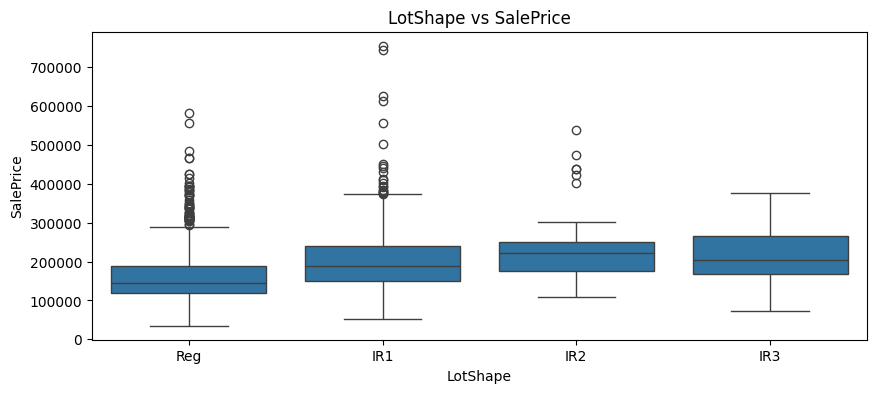

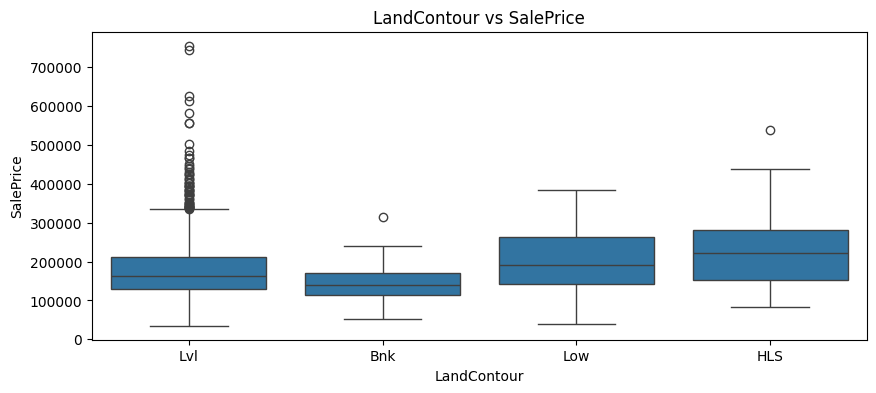

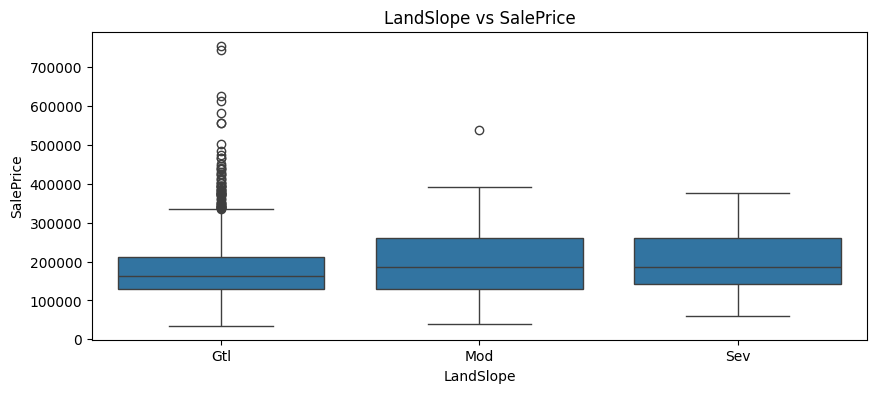

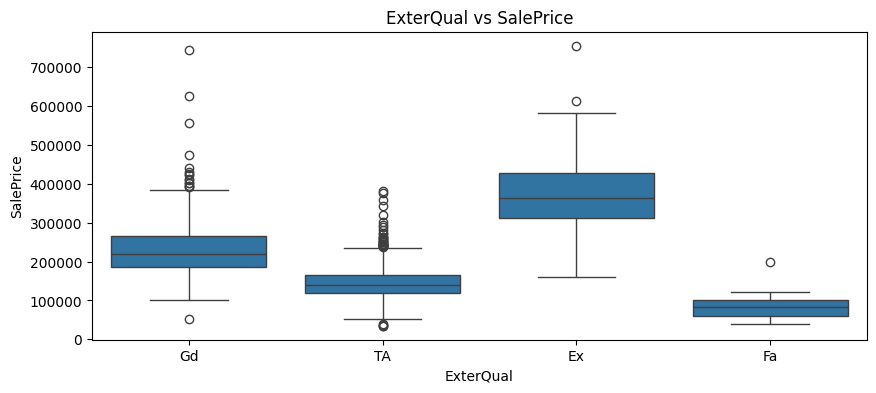

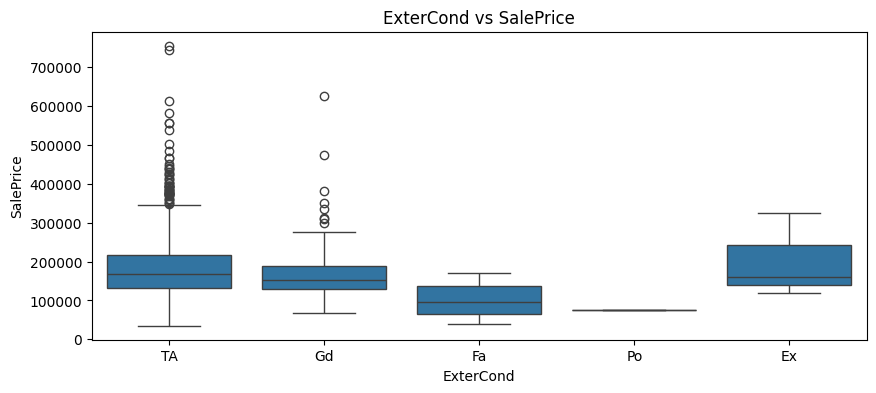

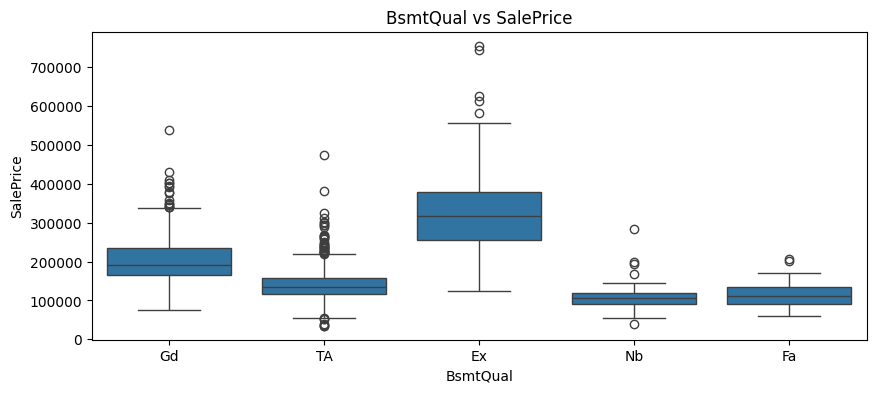

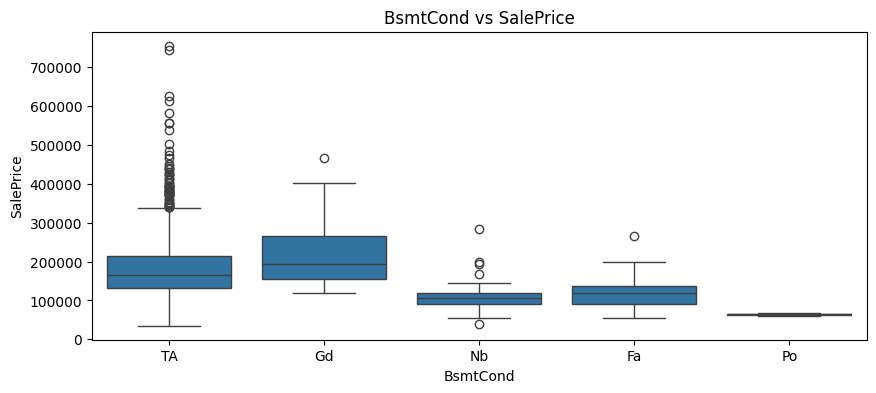

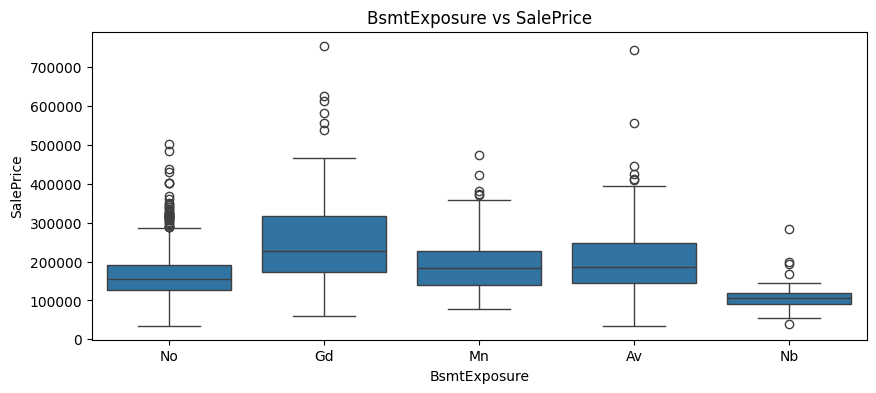

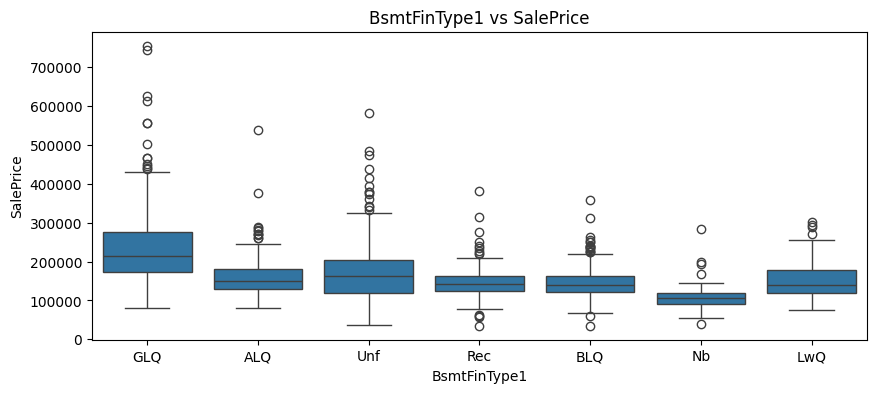

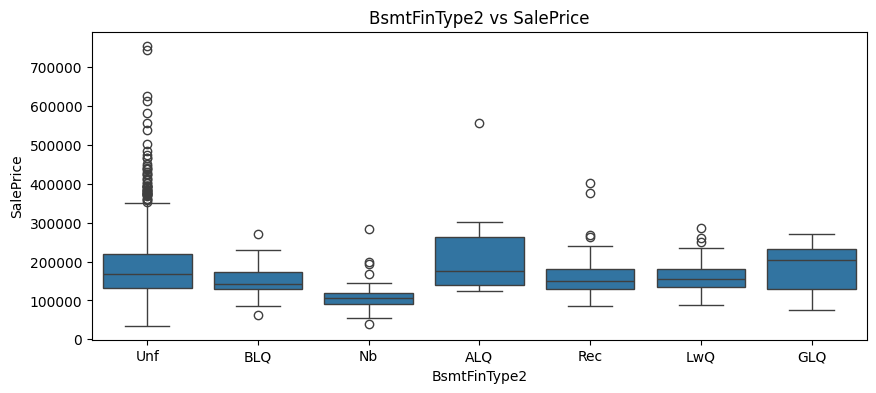

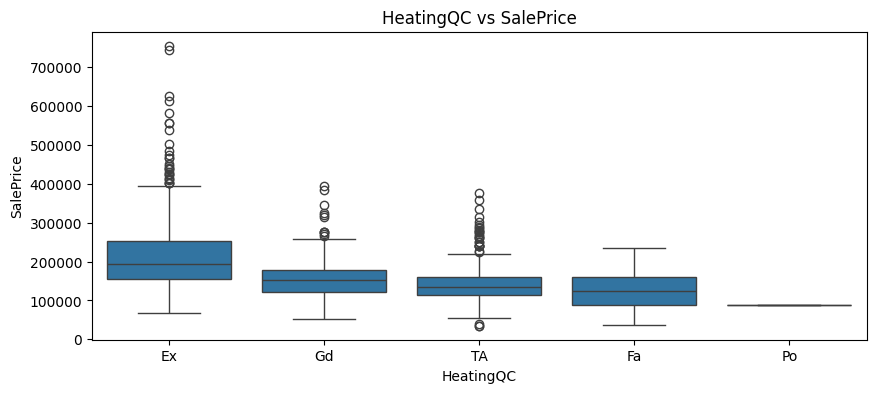

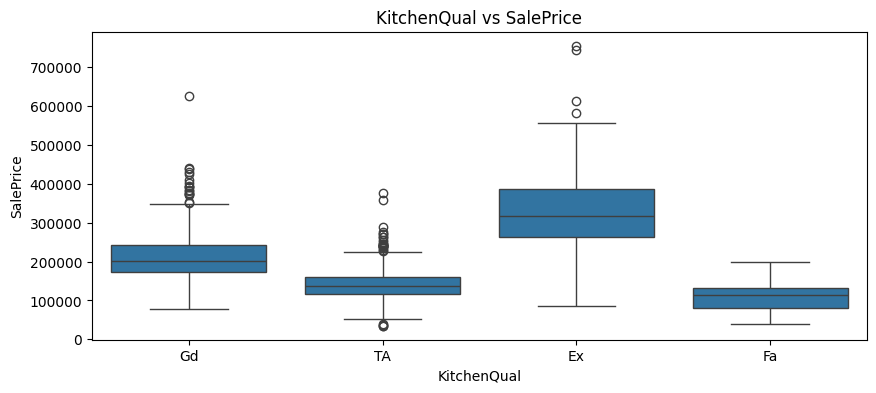

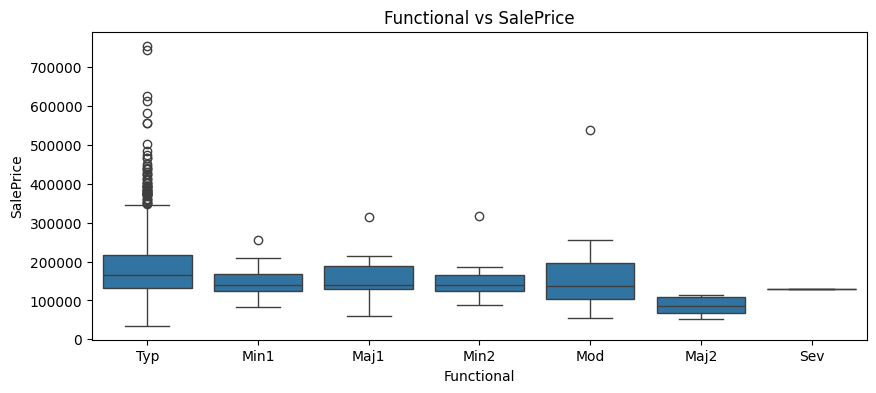

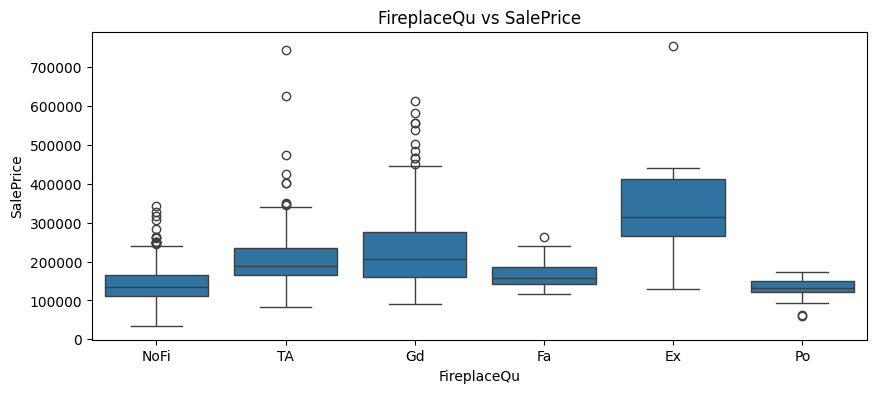

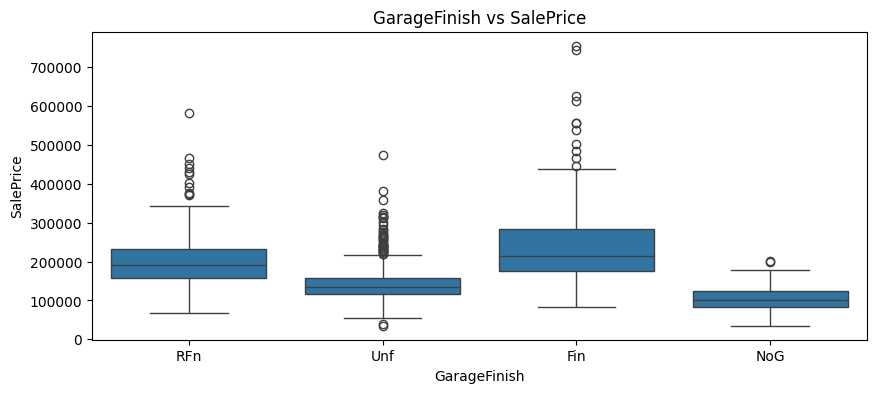

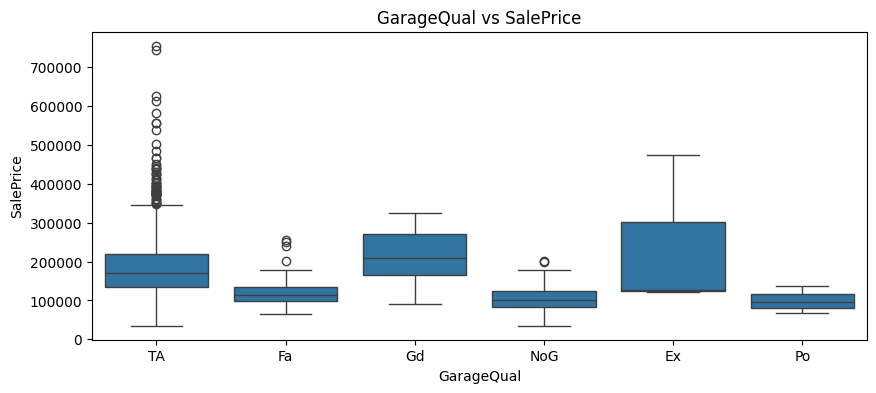

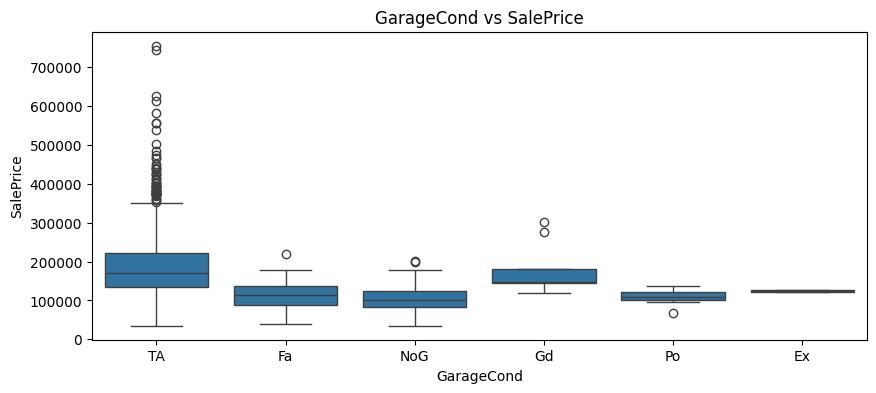

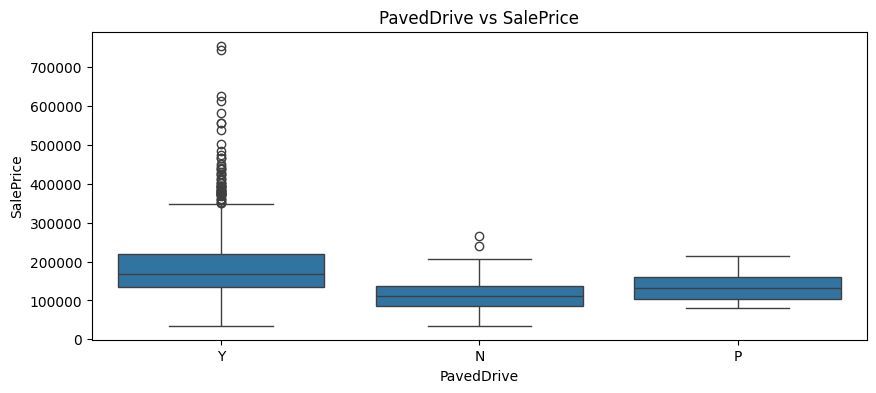

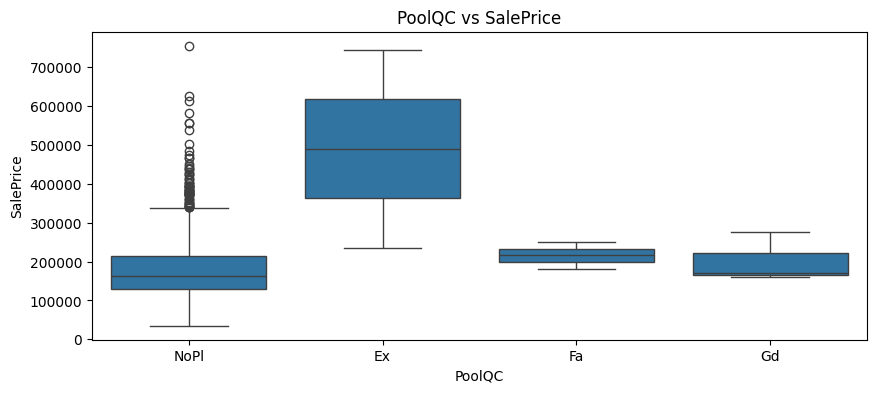

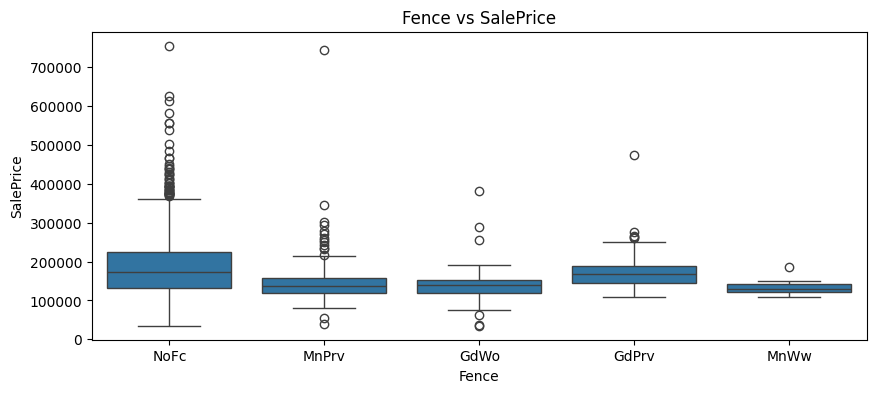

In [85]:
for col in encoding_feats['Ordinal']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col], y=df['SalePrice'])  # Use original categories
    plt.title(f'{col} vs SalePrice')
    plt.show()

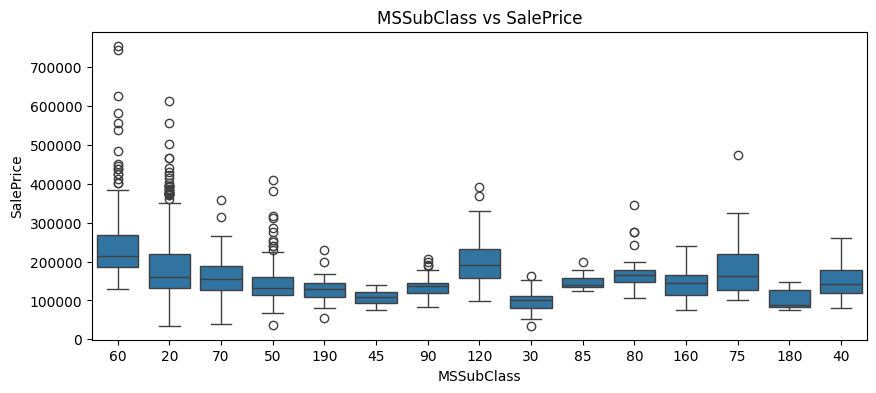

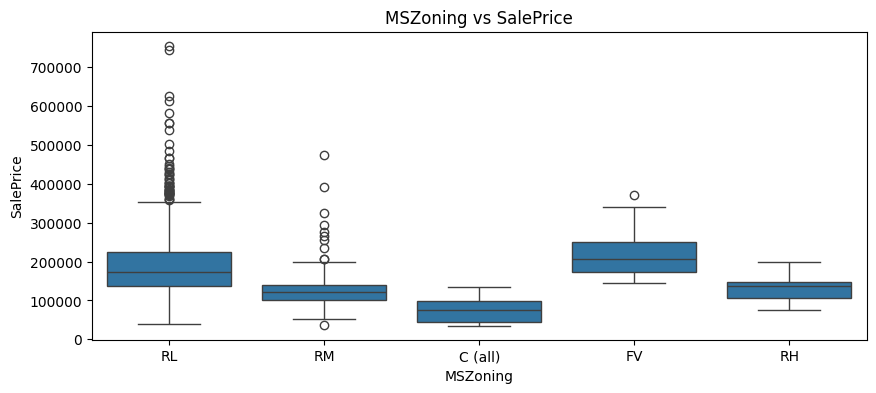

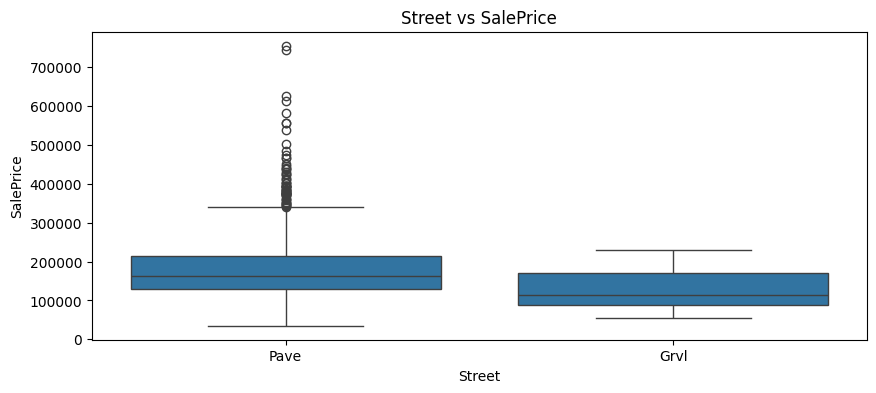

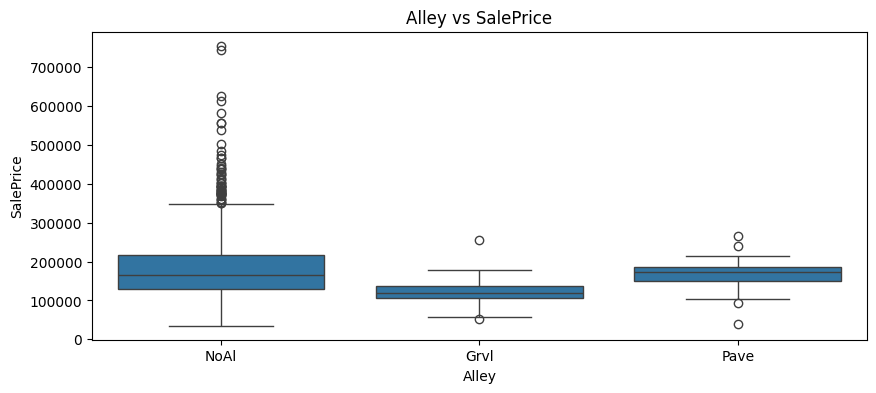

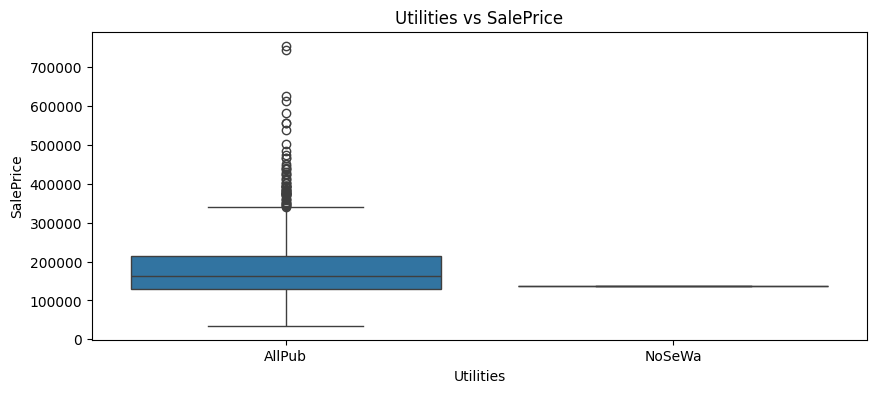

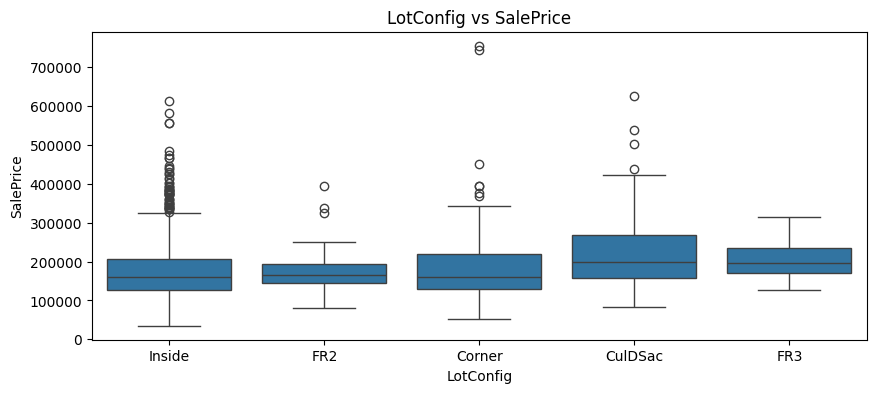

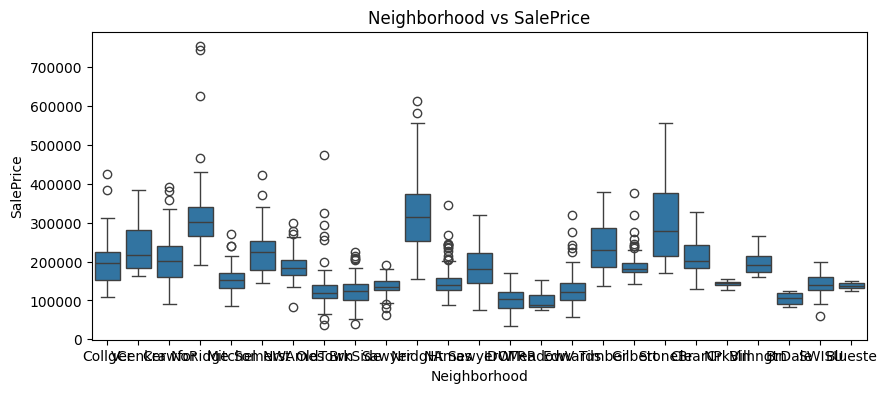

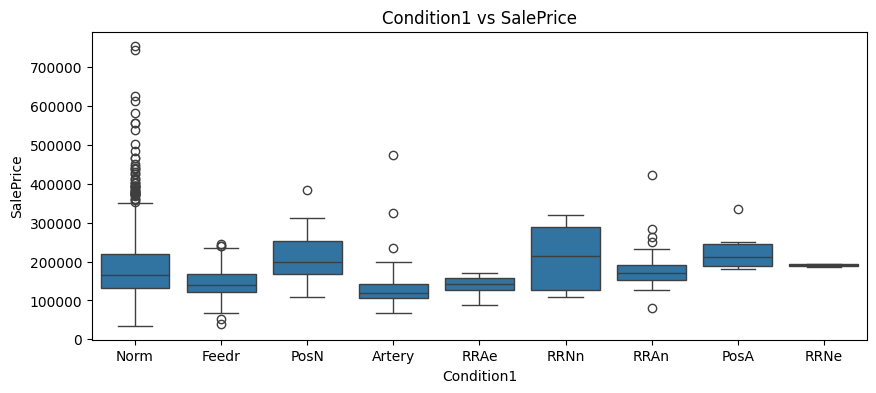

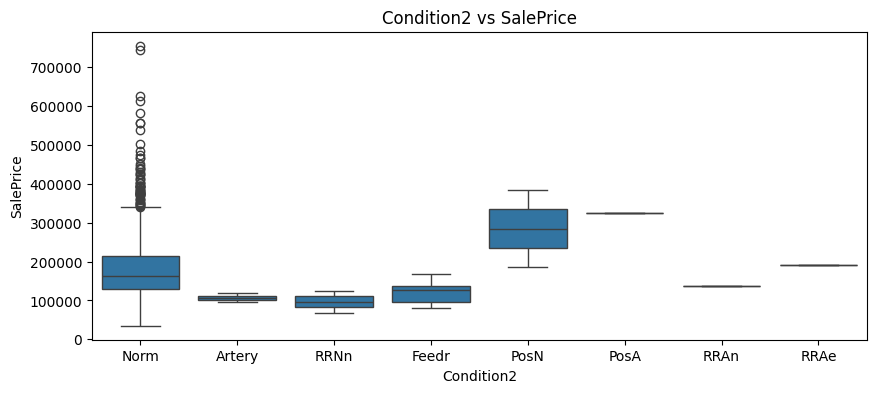

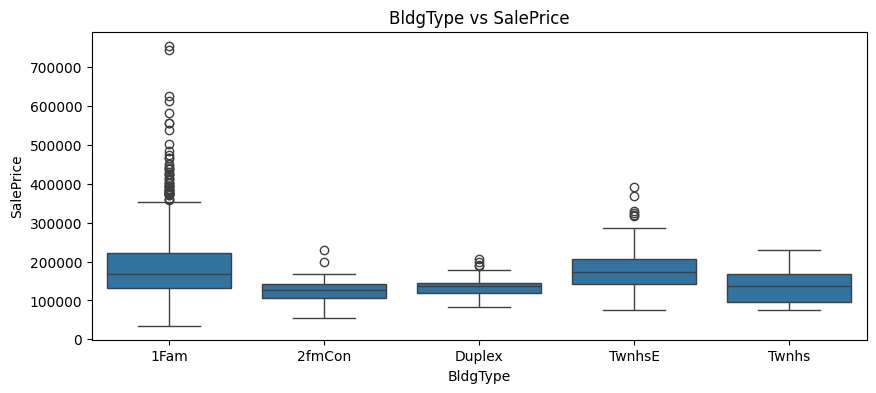

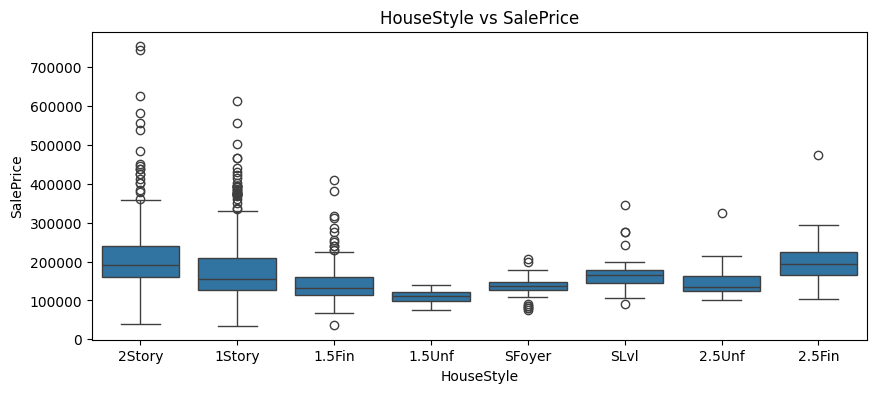

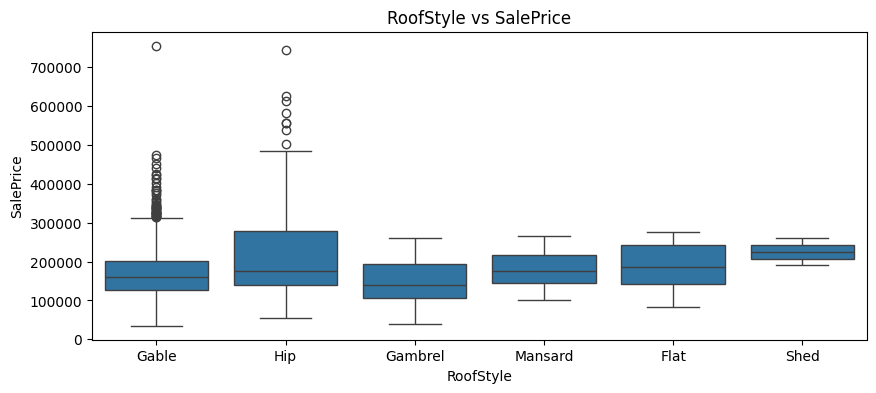

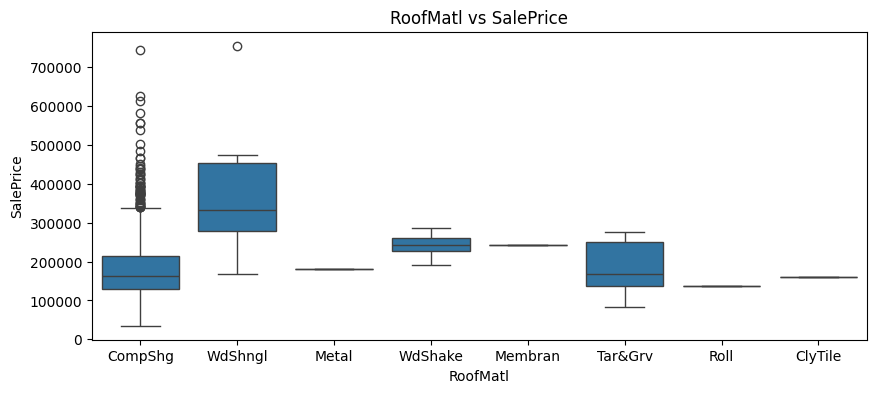

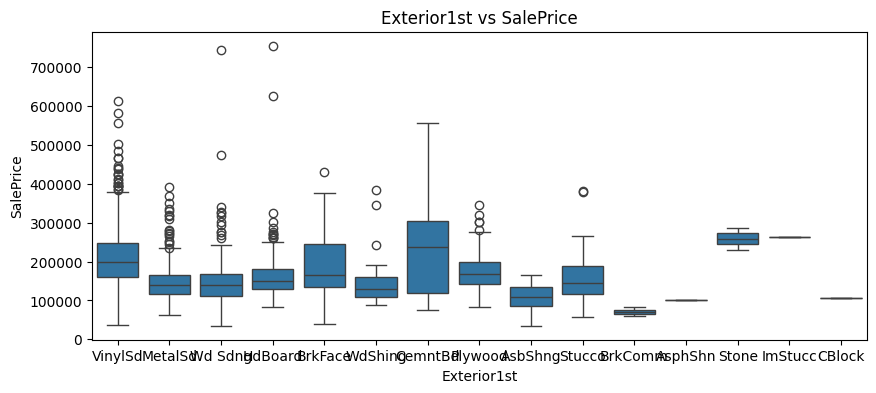

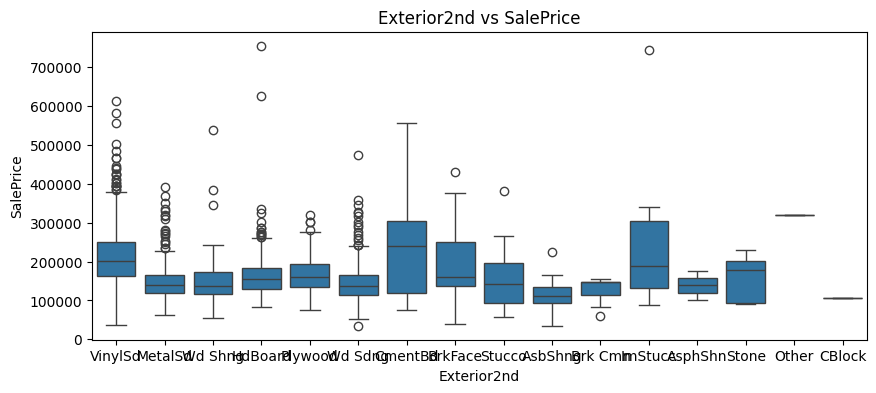

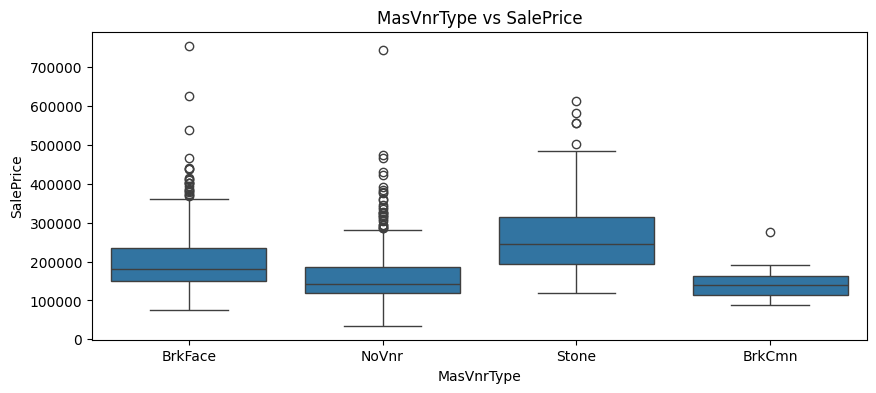

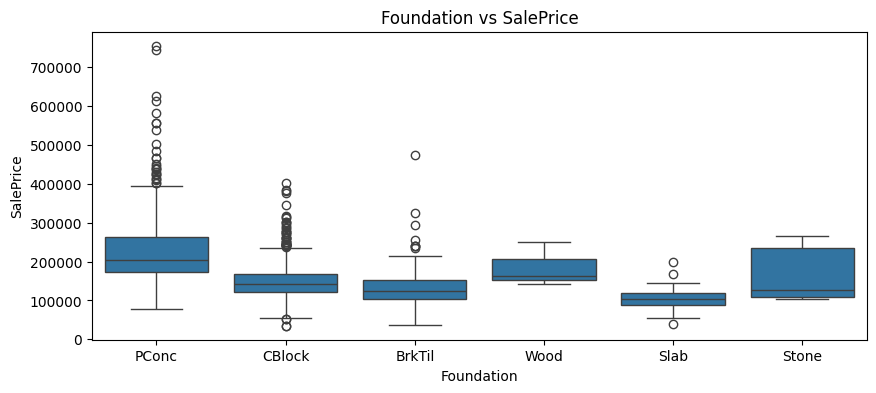

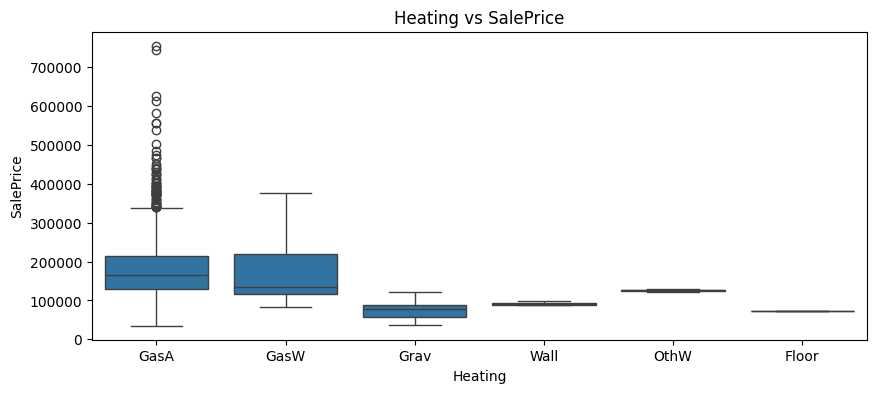

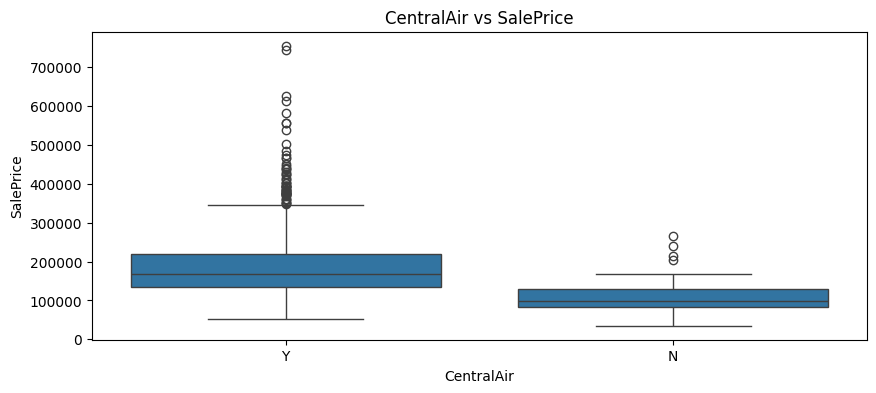

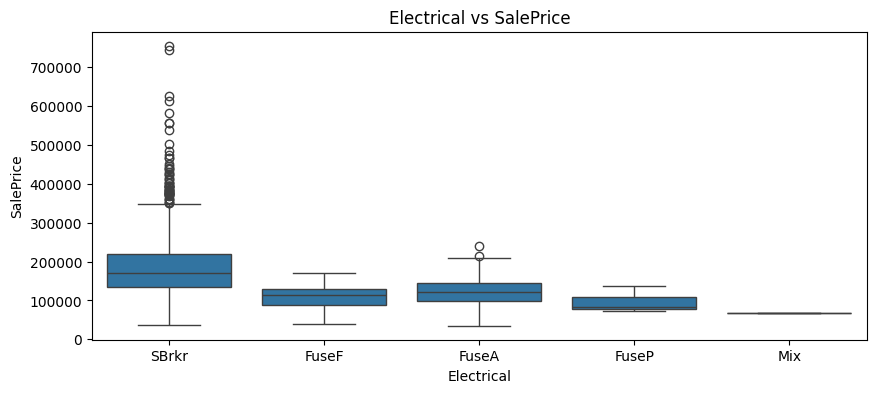

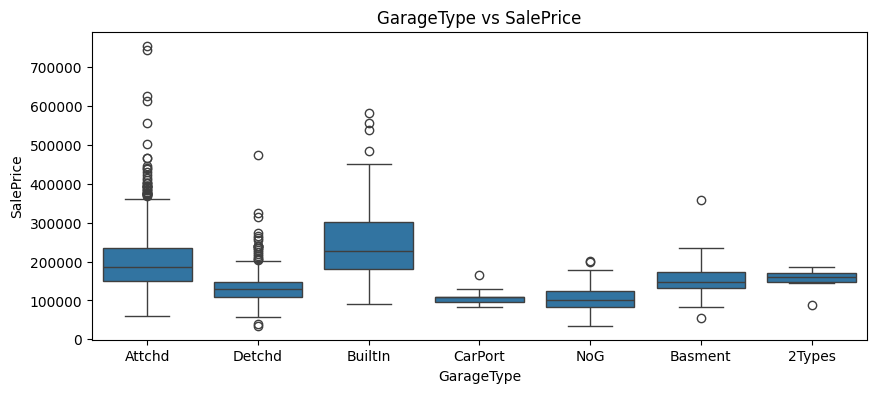

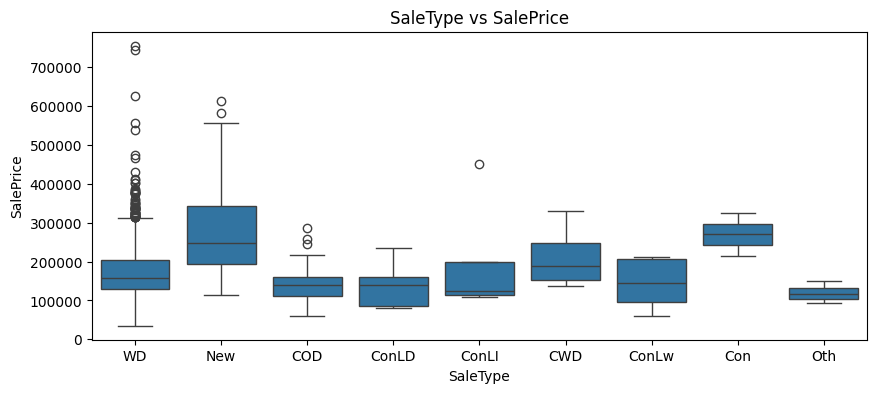

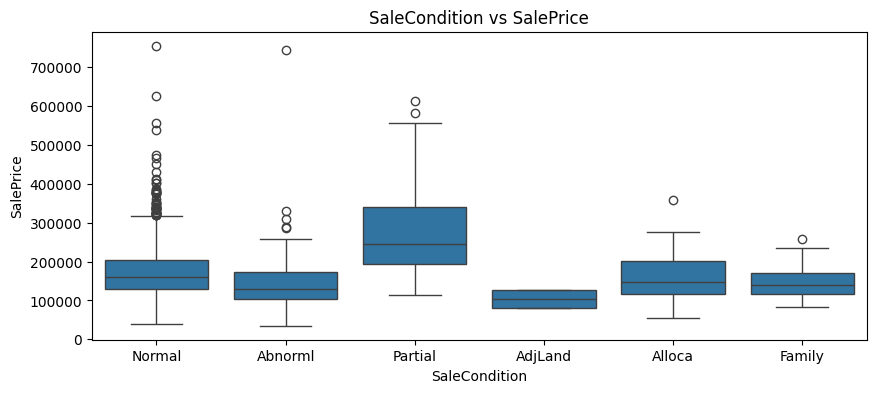

In [87]:
for col in encoding_feats['Nominal']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col], y=df['SalePrice'])  # Use original categories
    plt.title(f'{col} vs SalePrice')
    plt.show()

---
With these boxplots we can see which categorical columns are most influential to the SalePrice.